In [203]:
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from datetime import datetime
import numpy as np
import pandas as pd
from statsmodels.tsa import arima_process
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import acf
import plotly.express as px
import statsmodels.graphics.tsaplots as tsplots
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.tsa.forecasting.stl import STLForecast
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pylab import rcParams
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.arima_process import ArmaProcess
import math
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX 
from statsmodels.graphics.tsaplots import plot_predict

The last videos of the module took you through an approach to building ARMA models.

First, you learned about the importance of transforming your data into a stationary series. You tested for stationarity using the adfuller function and interpreted the value of the hypothesis test. If the data was not stationary, you learned how to apply strategies, such as differencing and logarithmic transformations, to achieve stationarity.

Once the series was stationary, building an ARMA model involved using autocorrelation and partial autocorrelation plots to determine the appropriate p and q parameters of the model.

This activity asks you to identify a time series of interest to you and build an ARMA model to construct a basic forecast for the series and analyze the error. You might also consider building models with different p and q parameters because, while ACF and PACF plots are helpful, they provide rough ideas of the appropriate parameters, and it is usually good practice to perform a simple grid search on these. 

Please find a time series dataset using any resource you would like, and present your model and findings to the class.

If you have trouble locating a dataset or would prefer a suggestion, try the Rossmann Store Sales Links to an external site.competition from Kaggle. This dataset involves forecasting retail store sales for a major drug store.

In [250]:
births = pd.read_csv('births.csv')
temps = pd.read_csv('daily_temps.csv')

In [251]:
births.head()
births.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Date    365 non-null    object
 1   Births  365 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 5.8+ KB


In [252]:
temps.head()
temps.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3650 entries, 0 to 3649
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    3650 non-null   object 
 1   Temp    3650 non-null   float64
dtypes: float64(1), object(1)
memory usage: 57.2+ KB


In [253]:
## Index with Time
temps['Date'] = pd.to_datetime(temps['Date'])
temps.set_index('Date', inplace = True)

In [254]:
temps

,Temp
Date,
1981-01-01,20.7
1981-01-02,17.9
1981-01-03,18.8
1981-01-04,14.6
1981-01-05,15.8
...,...
1990-12-27,14.0
1990-12-28,13.6
1990-12-29,13.5


In [255]:
temps2 = temps.resample('M').mean()
temps2.head()
temps2.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 120 entries, 1981-01-31 to 1990-12-31
Freq: M
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Temp    120 non-null    float64
dtypes: float64(1)
memory usage: 1.9 KB


In [256]:
temps2_train = temps2[:'01-01-1988']
temps2_test = temps2['01-01-1988':]
temps2_train.tail()
temps2_test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 36 entries, 1988-01-31 to 1990-12-31
Freq: M
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Temp    36 non-null     float64
dtypes: float64(1)
memory usage: 576.0 bytes


In [216]:
stl2 = STL(temps2_train, period = 12)
results = stl.fit()
season_and_trend = results.seasonal + results.trend


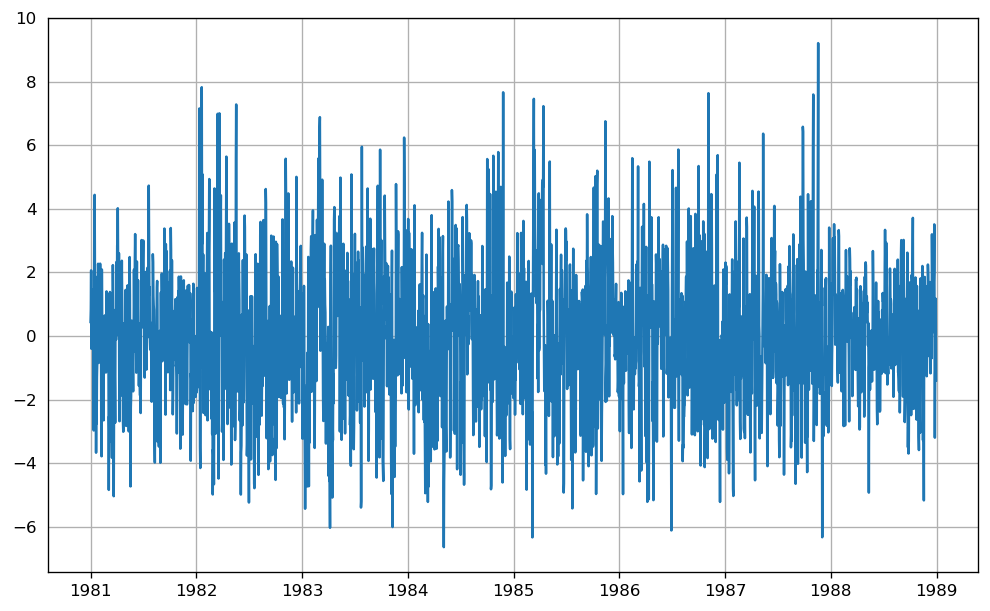

In [217]:
plt.plot(results.resid)
plt.grid()

In [218]:
#instantiate
stlf = STLForecast(temps2_train, ARIMA, model_kwargs={'order':(1, 1, 0), 'trend':"t"})
#fit model using historical data
stlf_results = stlf.fit()
#produce forecast for future data
forecast = stlf_results.forecast(len(temps2_test))

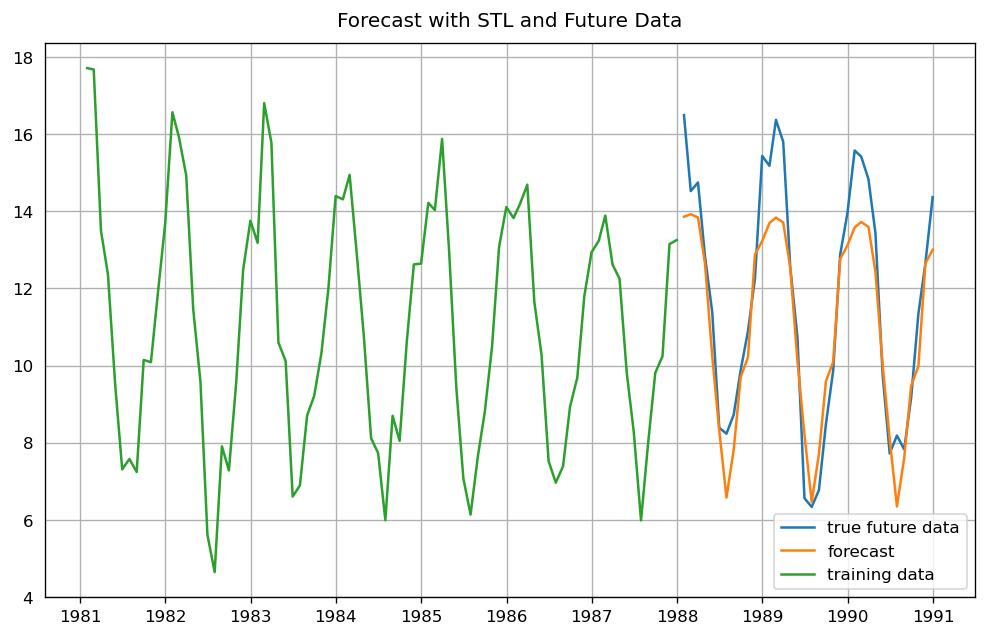

In [220]:
plt.plot(temps2_test, label = 'true future data')
plt.plot(forecast, label = 'forecast')
# plt.plot(y_hist['1993':], label = 'training data')
plt.plot(temps2_train, label = 'training data')
plt.legend()
plt.title('Forecast with STL and Future Data')
plt.grid();

In [222]:
pred_error = temps2['Temp'] - forecast
mae = np.abs(pred_error).mean()
rmse = np.sqrt((pred_error**2).mean())
### END SOLUTION

# Answer check
print(f'MAE: {mae}')
print(f'RMSE: {rmse}')

MAE: 0.9785160590115927
RMSE: 1.2323189488468864


## Visualize

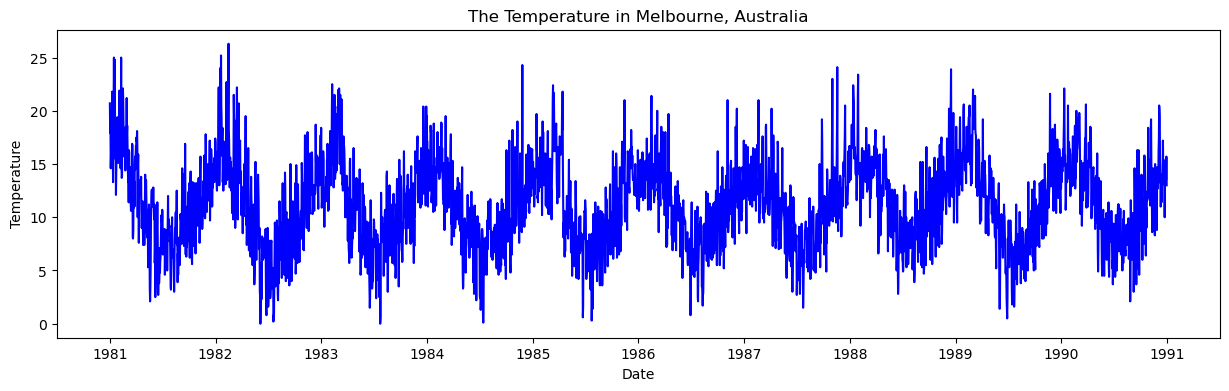

In [34]:
def plot_df(df, title="", xlabel='Date', ylabel='Temperature', dpi=100):
    plt.figure(figsize=(15,4), dpi=dpi)
    plt.plot(df, color='blue')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()
    

plot_df(temps, title='The Temperature in Melbourne, Australia')


We see a strong seasonality component.

## Decomposition

In [35]:
# Multiplicative Decomposition 
additive_decomposition = seasonal_decompose(temps['Temp'], model='additive', period=365)

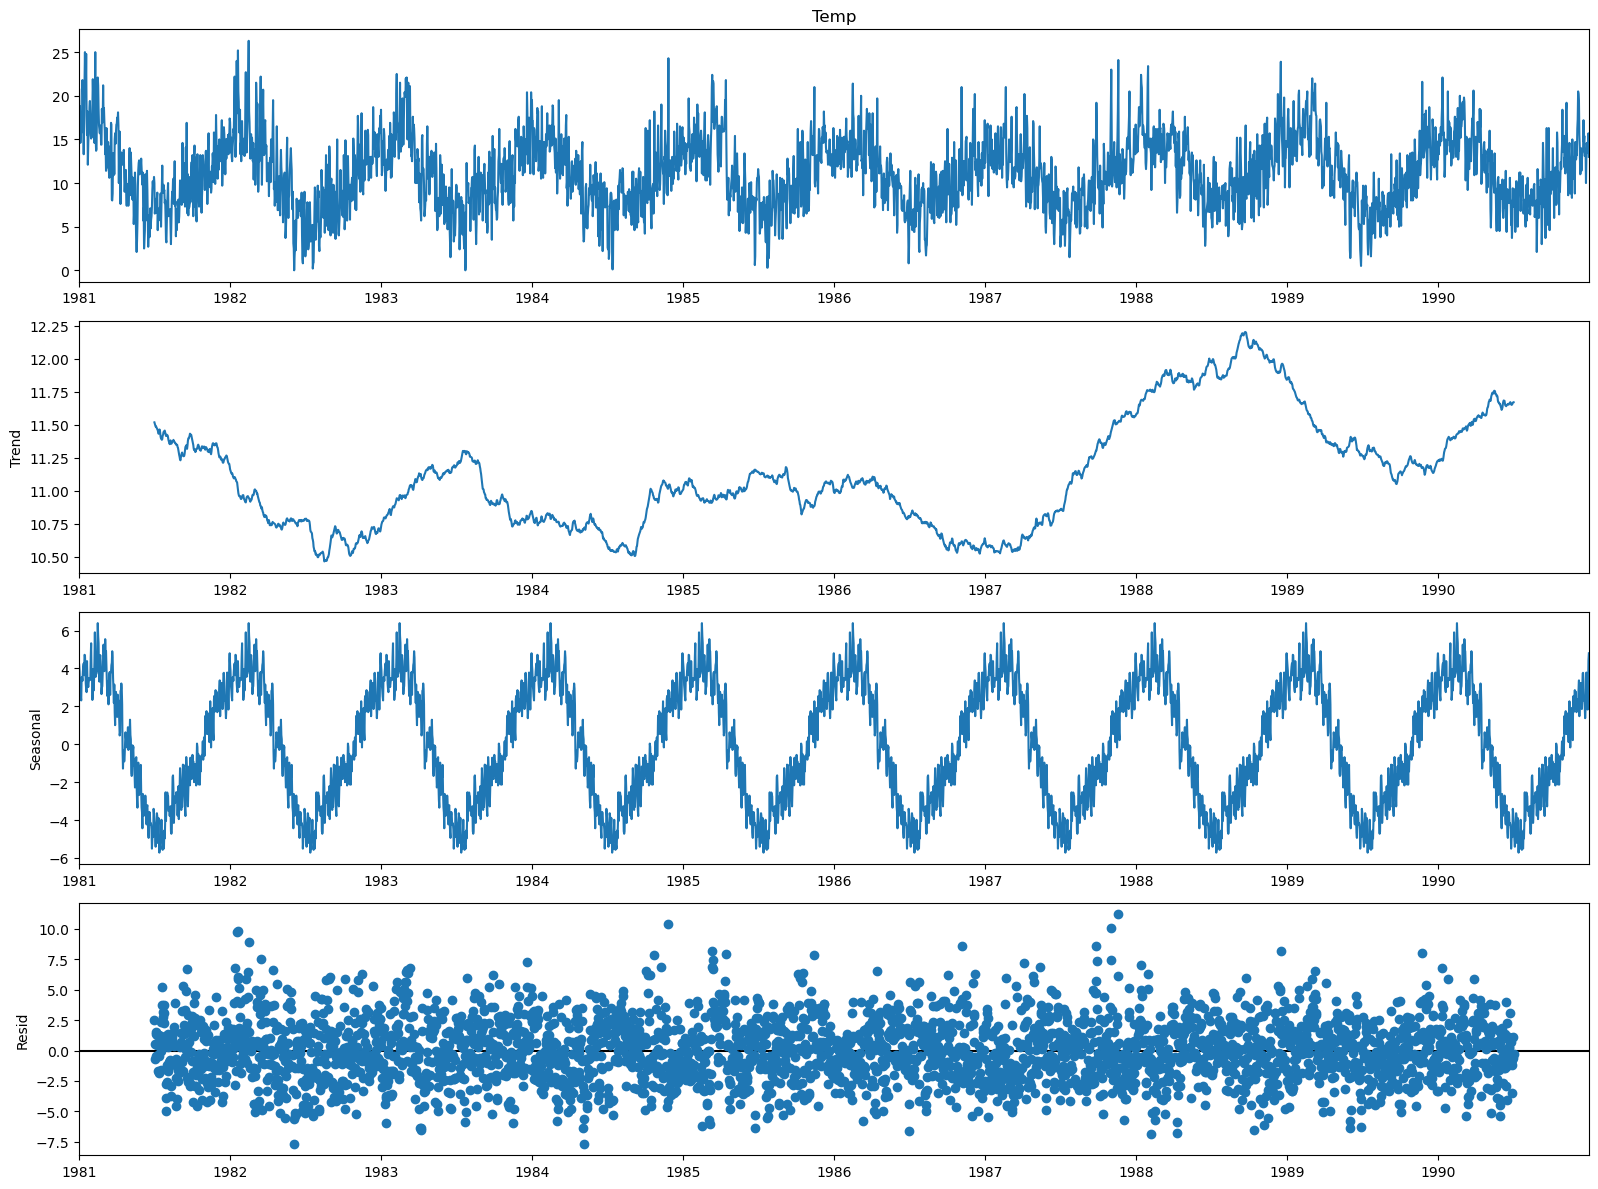

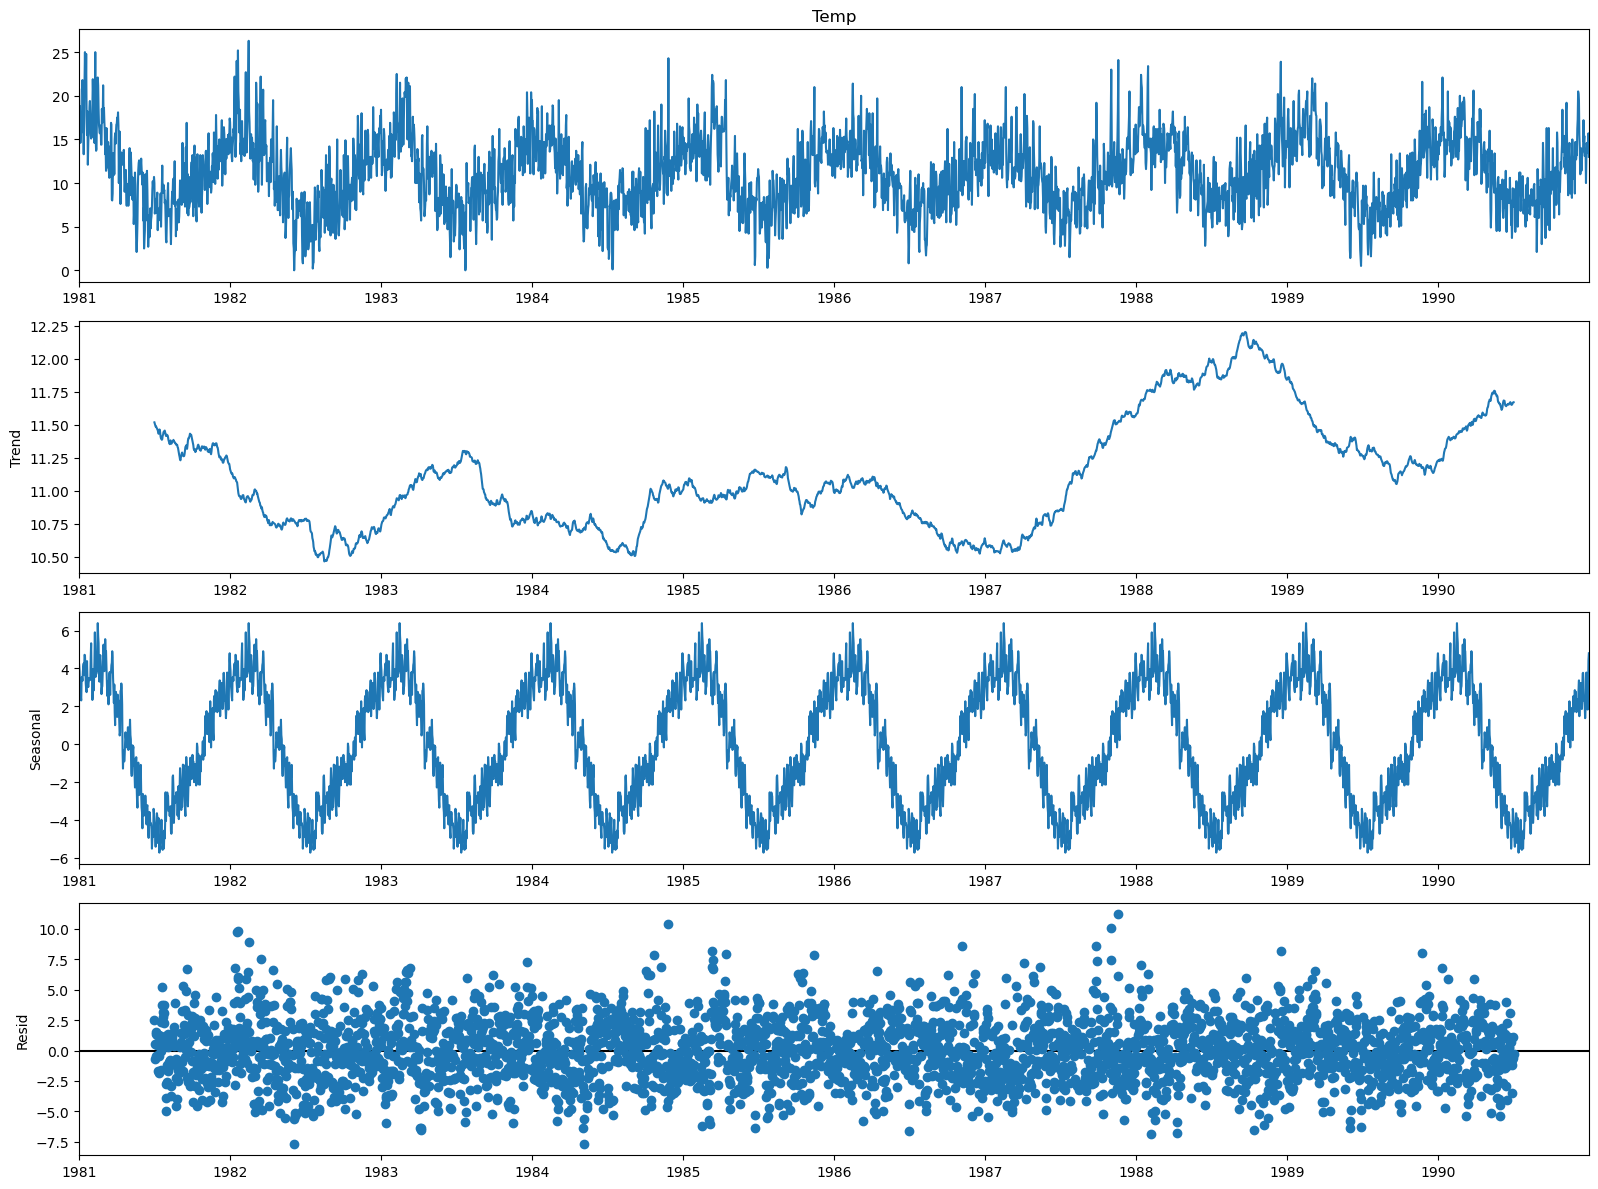

In [36]:
# Plot
plt.rcParams.update({'figure.figsize': (16,12)})
additive_decomposition.plot()

In [37]:
# We see a slight uptrend over time, a clear seasonality, and very little structure for the residue.

## Stationarity

In [40]:
adf = adfuller(temps['Temp'])
print(adf)
print("p-value of Temperatures is: {}".format(float(adf[1])))

(-4.444804924611683, 0.0002470826300361156, 20, 3629, {'1%': -3.4321532327220154, '5%': -2.862336767636517, '10%': -2.56719413172842}, 16642.822304301197)
p-value of Temperatures is: 0.0002470826300361156


In [223]:
# Examining Differenced Data
adj_diff = temps2['Temp'].diff().dropna()
results3 = adfuller(adj_diff)
print(results3)

(-4.629576365009956, 0.00011389116578307212, 12, 106, {'1%': -3.4936021509366793, '5%': -2.8892174239808703, '10%': -2.58153320754717}, 314.6084436365842)


Very small p-value(lower than .05) and statistic below thresholds, thus we can reject and show that the data is stationary.

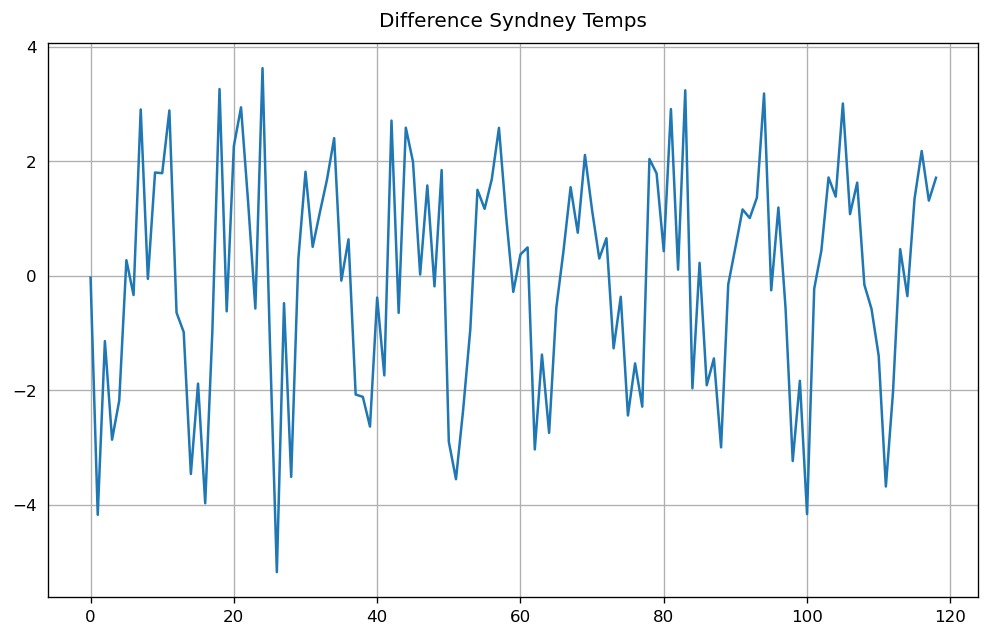

In [224]:
plt.plot(adj_diff.values)
plt.title('Difference Syndney Temps')
plt.grid();

In [225]:
#Checking the Residuals
stl3 = STL(temps2)
results4 = stl3.fit()
checking = adfuller(results4.resid)
checking
# Residuals are also stationary

(-5.387643554266298,
 3.5956070392863625e-06,
 12,
 107,
 {'1%': -3.492995948509562,
  '5%': -2.888954648057252,
  '10%': -2.58139291903223},
 178.90507384284757)

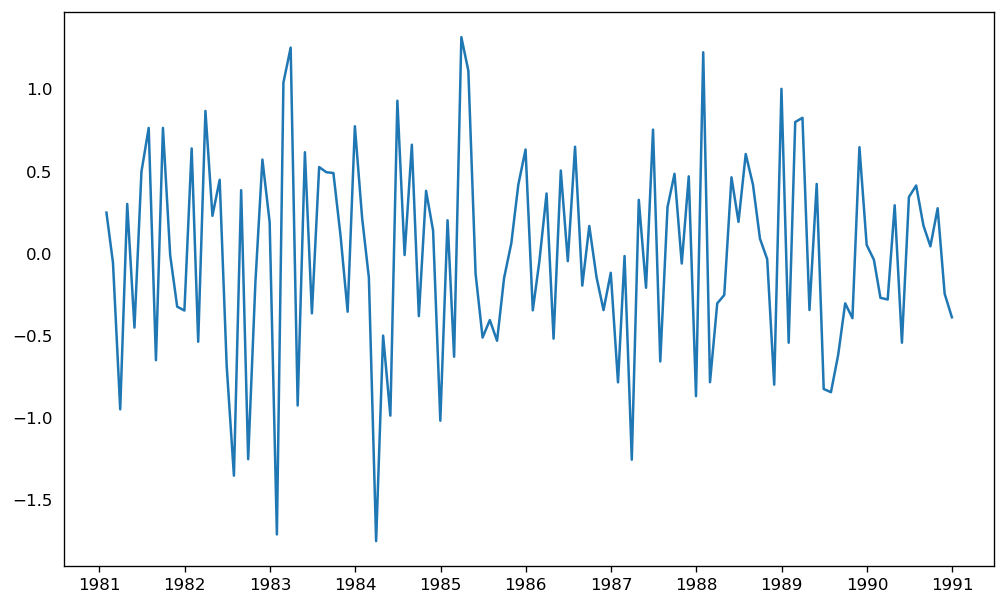

In [227]:
plt.plot(results4.resid)

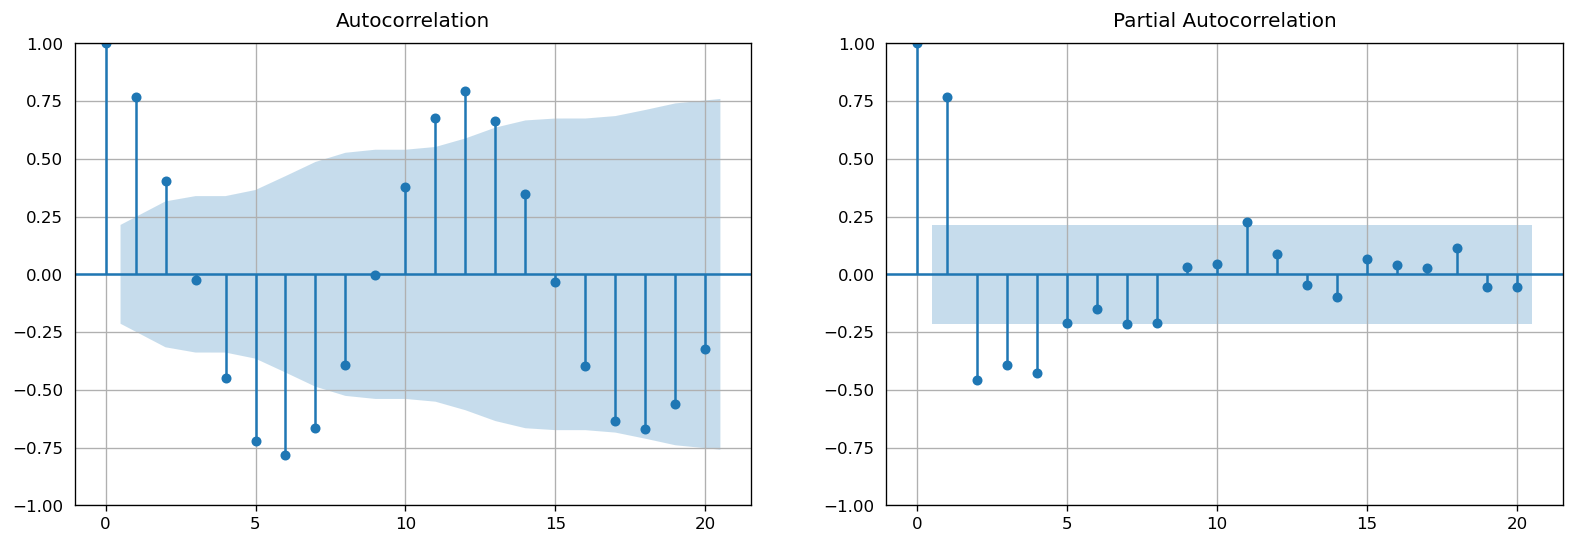

In [228]:
#Examining the acf and pacf plots
fig, ax = plt.subplots(1, 2, figsize = (16, 5))
plot_acf(temps2_train, ax = ax[0]);
ax[0].grid()
plot_pacf(temps2_train, ax = ax[1], method = 'ywm');
ax[1].grid()

ACF plot not that helpful since it goes in/out of negligibe...PACA suggests a value of p=4 in an ARMA model. 

In [233]:
arma2 = ARIMA(temps2_train['Temp'], order = (4,0,1)).fit()
arma2

In [235]:
# Make predictions
hist_preds = arma2.predict()
hist_preds.tail()

Date
1987-08-31     7.414780
1987-09-30     9.119433
1987-10-31    11.182979
1987-11-30    12.661320
1987-12-31    14.182186
Freq: M, Name: predicted_mean, dtype: float64

In [257]:
temps2_test.head()

,Temp
Date,
1988-01-31,16.493548
1988-02-29,14.524138
1988-03-31,14.748387
1988-04-30,12.833333
1988-05-31,11.387097


In [260]:
# forecast
temps2_test.index = pd.to_datetime(temps2_test.index)
future_preds = arma2.forecast(steps = len(temps2_test))
future_preds.tail()

1990-08-31     9.090954
1990-09-30     9.964832
1990-10-31    11.082372
1990-11-30    12.137735
1990-12-31    12.848530
Freq: M, Name: predicted_mean, dtype: float64

In [261]:
pred_error2 = temps2_test['Temp'] - future_preds
mae = np.abs(pred_error2).mean()
rmse = np.sqrt((pred_error2**2).mean())
### END SOLUTION

# Answer check
print(f'MAE: {mae}')
print(f'RMSE: {rmse}')

MAE: 1.3676413750369898
RMSE: 1.6602489817090773


In [263]:
# SARIMA
sarima = SARIMAX(temps2_test, order = (4,0,1), seasonal_order = (1,1,0,12)).fit(disp=0)
sarima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                Temp   No. Observations:                   36
Model:             SARIMAX(4, 0, 1)x(1, 1, [], 12)   Log Likelihood                 -32.070
Date:                             Mon, 21 Nov 2022   AIC                             78.140
Time:                                     13:05:42   BIC                             86.386
Sample:                                 01-31-1988   HQIC                            80.328
                                      - 12-31-1990                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3900      1.658      0.235      0.814      -2.860       3.641
ar.L2          0.2238      0.327      0.686      0.493      -0.416       0.864
ar.L3          0.0810      0.506      0.160      0.873      -0.911       1.073
ar.L4         -0.1817      0.368     -0.494      0.621      -0.902       0.539
ma.L1         -0.2534      1.697     -0.149      0.881      -3.580       3.073
ar.S.L12      -0.6365      0.208     -3.065      0.002      -1.043      -0.229
sigma2         0.6455      0.318      2.028      0.043       0.022       1.269
===================================================================================
Ljung-Box (L1) (Q):                   0.10   Jarque-Bera (JB):                 1.06
Prob(Q):                              0.76   Prob(JB):                         0.59
Heteroskedasticity (H):               0.53   Skew:                             0.35
Prob(H) (two-sided):                  0.39   Kurtosis:                         2.24
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [280]:
# Make predictions
hist_preds2 = sarima.predict()
hist_preds2.head()

Date
1988-01-31    0.000000
1988-02-29    0.000004
1988-03-31    0.000009
1988-04-30    0.000013
1988-05-31    0.000012
Freq: M, Name: predicted_mean, dtype: float64

In [272]:
# forecast
temps2_test.index = pd.to_datetime(temps2_test.index)
temps2_test.head()
future_preds2 = sarima.forecast(steps = len(temps2_test))
future_preds2.head()

1991-01-31    15.451266
1991-02-28    15.819771
1991-03-31    15.324790
1991-04-30    12.890694
1991-05-31    10.306885
Freq: M, Name: predicted_mean, dtype: float64

Text(0.5, 1.0, 'The SARIMA Model')

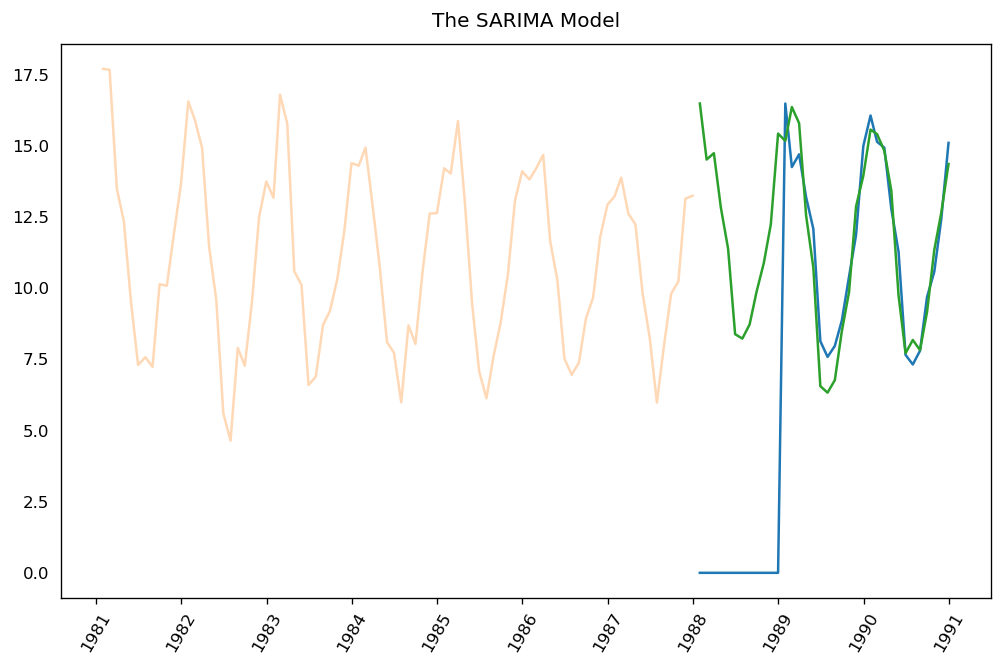

In [286]:
plt.plot(temps2_test.index, sarima.predict())
plt.plot(temps2_train.index, temps2_train, alpha = 0.3)
plt.plot(temps2_test)
plt.xticks(rotation = 60)
plt.title('The SARIMA Model')
# plt.grid();

## Detrending

Text(0.5, 1.0, 'Temperatures detrended by subtracting the trend component')

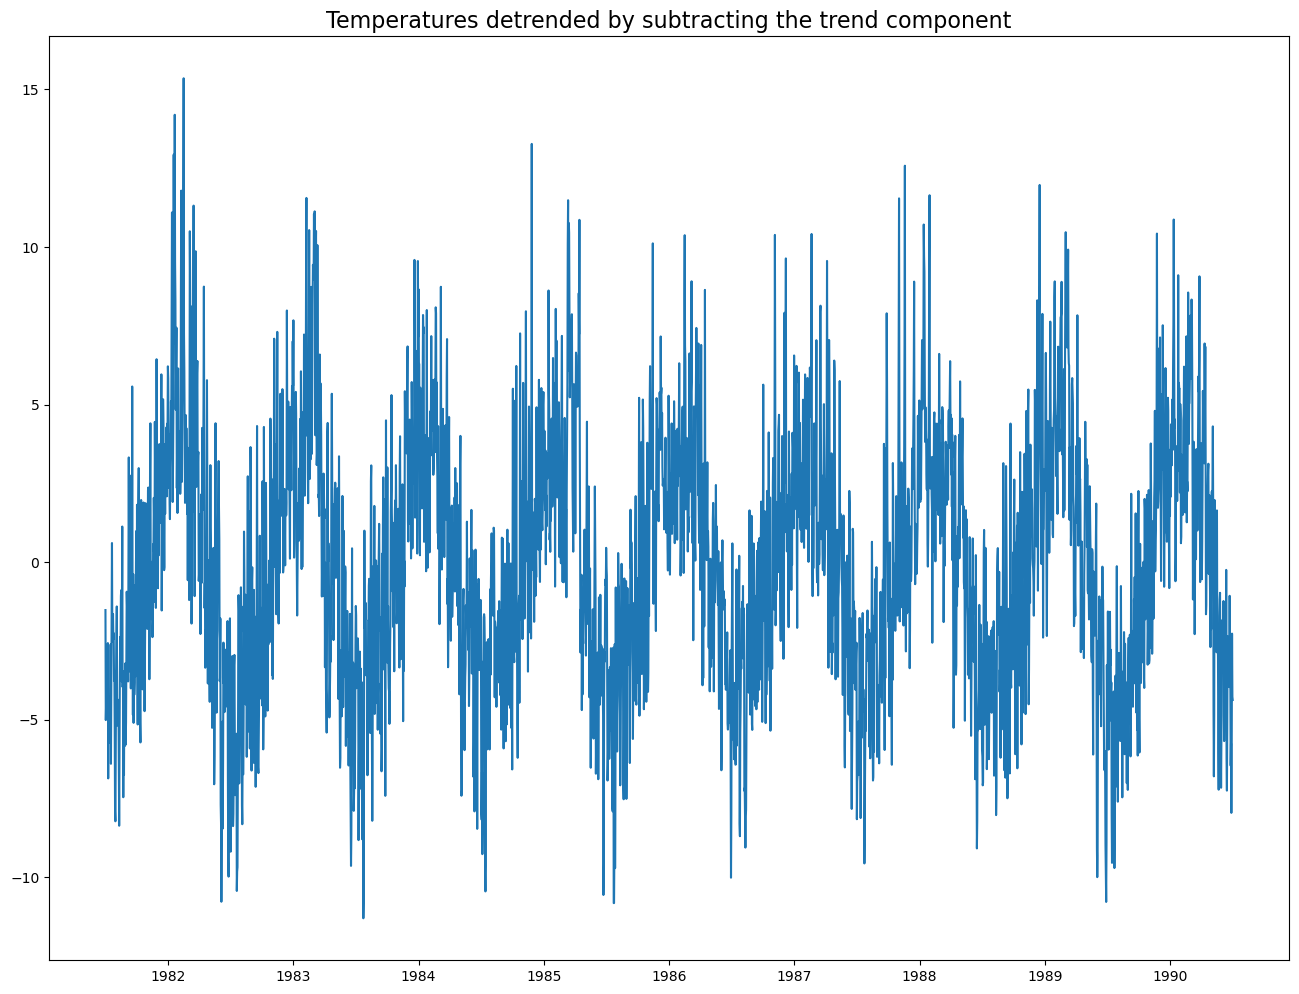

In [43]:
# Using statsmodels subtract the trend
# Using statmodels: Subtracting the Trend Component
result_mul = seasonal_decompose(temps['Temp'], model='additive', period=365)
detrended = temps['Temp'].values - result_mul.trend
plt.plot(detrended)
plt.title('Temperatures detrended by subtracting the trend component', fontsize=16)

## DeSeasonalize

Text(0.5, 1.0, 'Air Passengers DeSeasonalized')

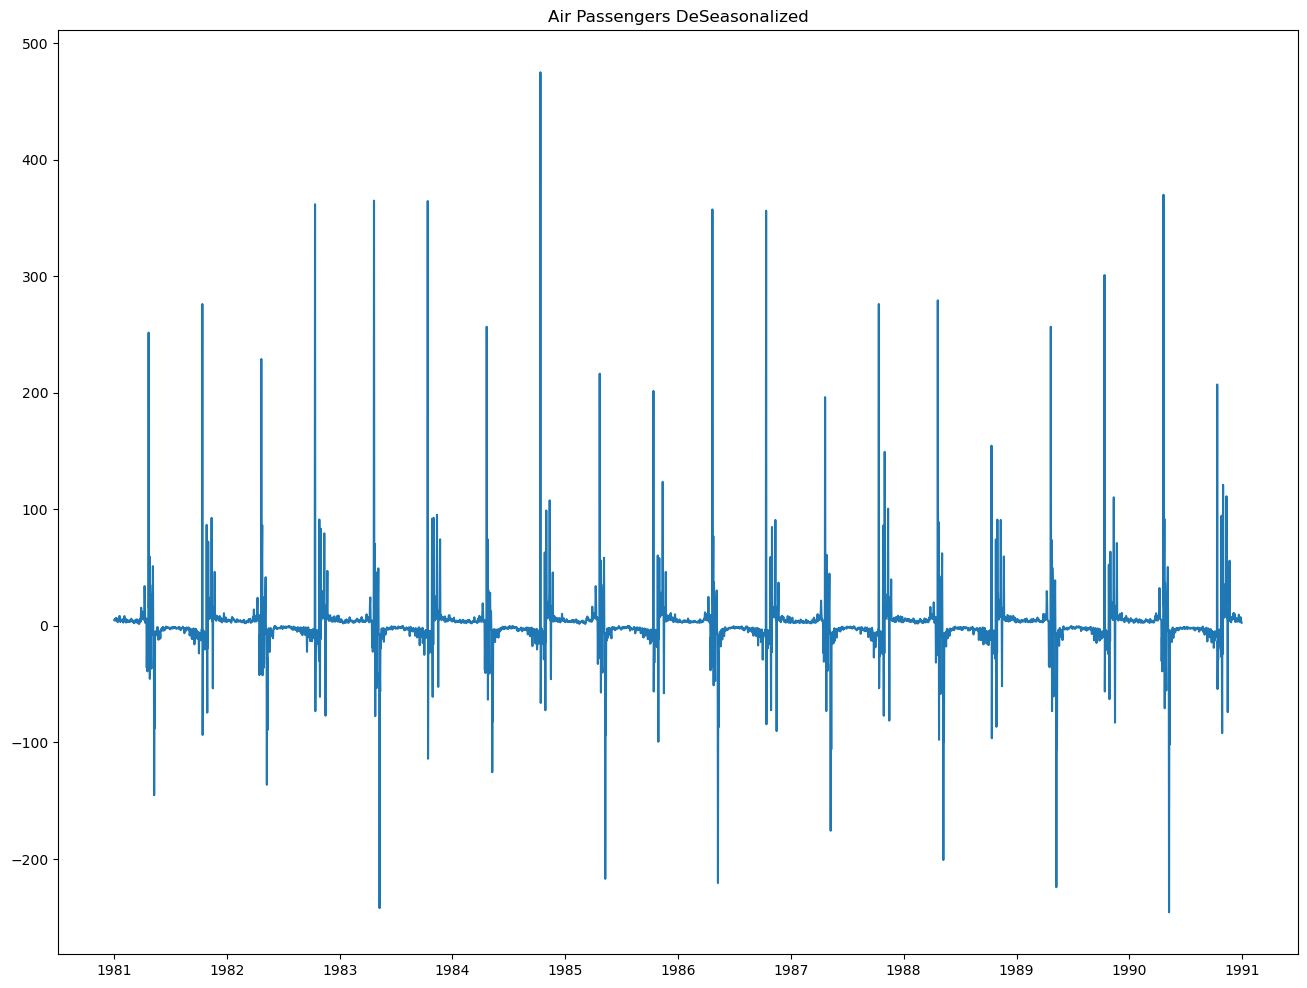

In [46]:
deseasonalized = temps['Temp'].values / result_mul.seasonal
plt.plot(deseasonalized)
plt.title('Air Passengers DeSeasonalized')

## Testing for Seasonality

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

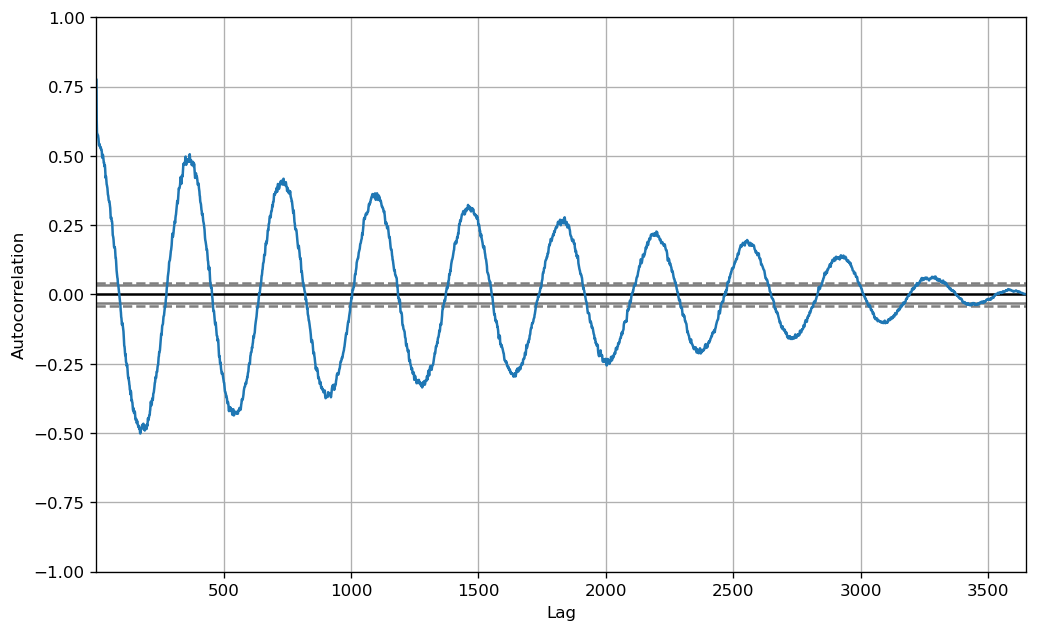

In [47]:
# Test for seasonality
from pandas.plotting import autocorrelation_plot

# Draw Plot
plt.rcParams.update({'figure.figsize':(10,6), 'figure.dpi':120})
autocorrelation_plot(temps['Temp'].tolist())

## ACF and PACF

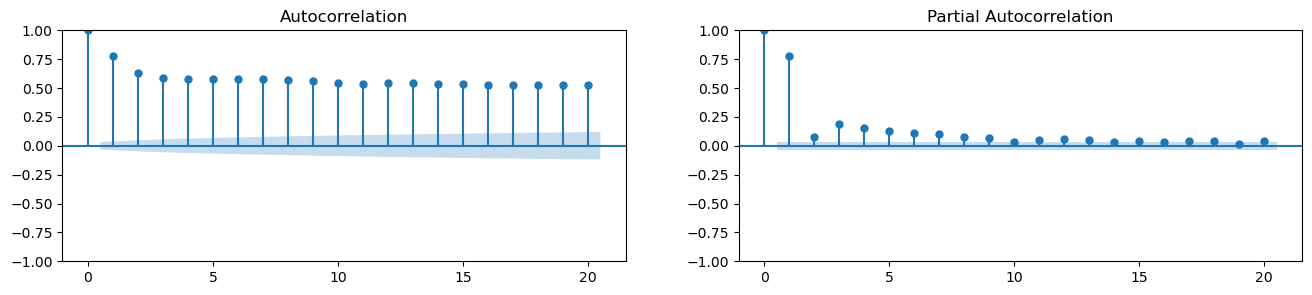

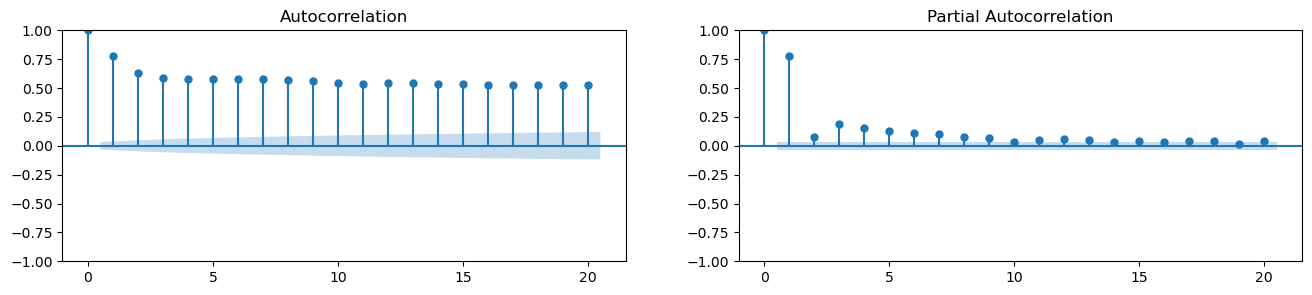

In [49]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Draw Plot
fig, axes = plt.subplots(1,2,figsize=(16,3), dpi= 100)
plot_acf(temps['Temp'].tolist(), lags=20, ax=axes[0])
plot_pacf(temps['Temp'].tolist(), lags=20, ax=axes[1])

## Lag Plots
A Lag plot is a scatter plot of a time series against a lag of itself. It is normally used to check for autocorrelation. If there is any pattern existing in the series, the series is autocorrelated. If there is no such pattern, the series is likely to be random white noise.

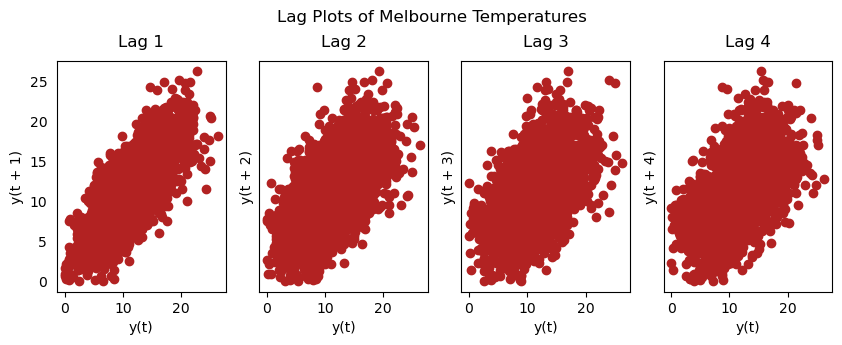

In [50]:
from pandas.plotting import lag_plot
plt.rcParams.update({'ytick.left' : False, 'axes.titlepad':10})

# Plot
fig, axes = plt.subplots(1, 4, figsize=(10,3), sharex=True, sharey=True, dpi=100)
for i, ax in enumerate(axes.flatten()[:4]):
    lag_plot(temps['Temp'], lag=i+1, ax=ax, c='firebrick')
    ax.set_title('Lag ' + str(i+1))

fig.suptitle('Lag Plots of Melbourne Temperatures', y=1.05)    
plt.show()

## ARIMA Model for Time Series Forecasting

So, ARIMA, short for AutoRegressive Integrated Moving Average, is a forecasting algorithm based on the idea that the information in the past values of the time series can alone be used to predict the future values.

ARIMA Models are specified by three order parameters: (p, d, q),


p is the order of the Auto Regressive (AR) term. It refers to the number of lags of Y to be used as predictors.

The value of d, therefore, is the minimum number of differencing needed to make the series stationary. If the time series is already stationary, then d = 0.

q is the order of the Moving Average (MA) term. It refers to the number of lagged forecast errors that should go into the ARIMA Model.

An ARIMA model is one where the time series was differenced at least once to make it stationary and we combine the AR and the MA terms. 

In [53]:
model = ARIMA(temps['Temp'], order = (1, 0, 2))

/Users/leostern/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/leostern/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/leostern/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [56]:
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                   Temp   No. Observations:                 3650
Model:                 ARIMA(1, 0, 2)   Log Likelihood               -8403.185
Date:                Sun, 20 Nov 2022   AIC                          16816.370
Time:                        11:44:44   BIC                          16847.383
Sample:                             0   HQIC                         16827.415
                               - 3650                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.4262      0.743     15.371      0.000       9.969      12.883
ar.L1          0.9908      0.003    391.171      0.000       0.986       0.996
ma.L1         -0.4374      0.015    -29.544      0.0

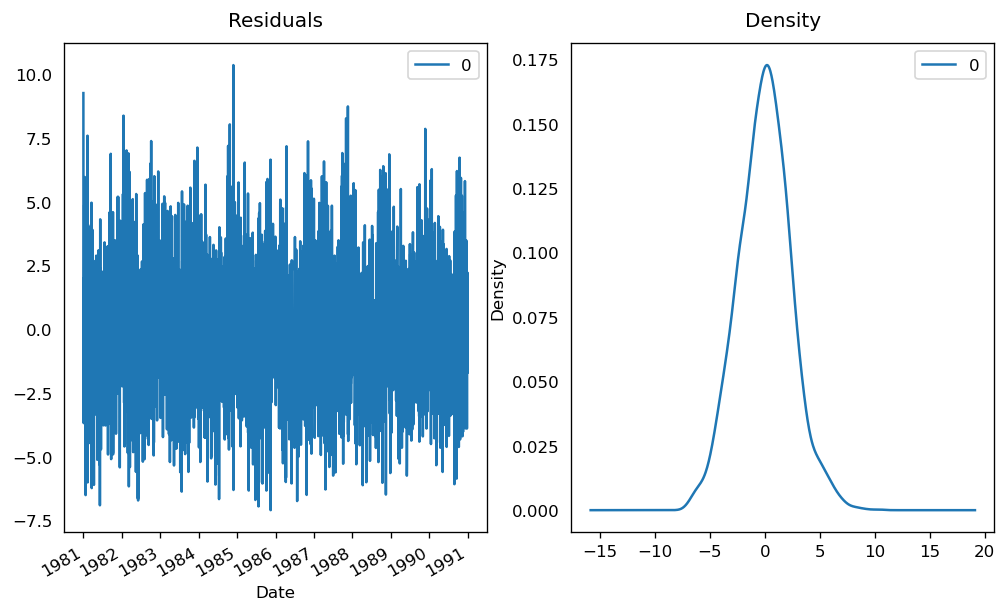

In [57]:
# Plot Residual Errors
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

In [59]:
# Actual vs. Fitted
model_fit.predict(dynamic=False)


Date
1981-01-01    11.426183
1981-01-02    18.530582
1981-01-03    16.810370
1981-01-04    18.281461
1981-01-05    15.270548
                ...    
1990-12-27    13.790324
1990-12-28    13.597413
1990-12-29    13.499484
1990-12-30    13.479678
1990-12-31    14.689237
Name: predicted_mean, Length: 3650, dtype: float64

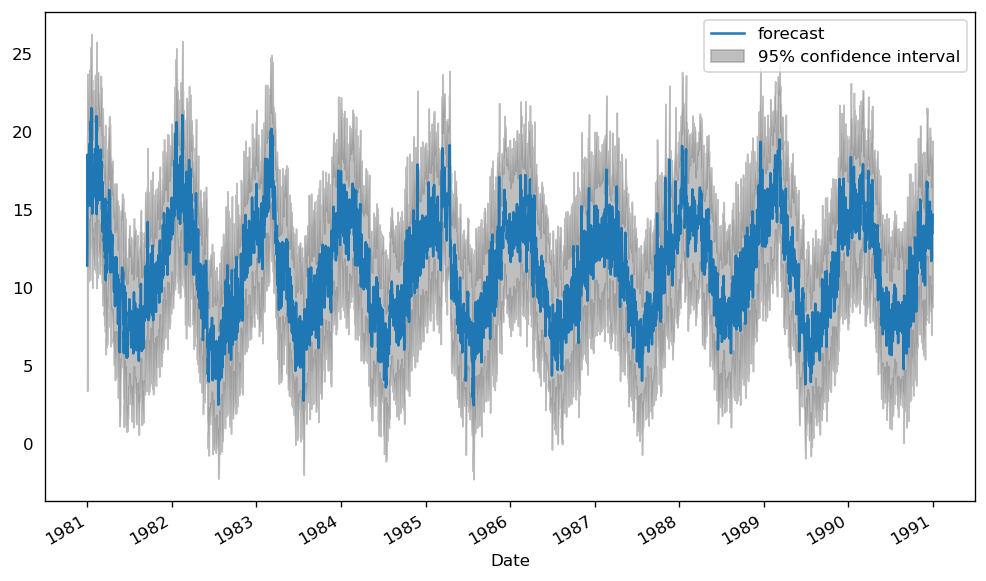

In [68]:
# Actual vs Fitted....method is obsolete so must use the function...
plot_predict(model_fit, dynamic=False)
plt.show()

In [61]:
# Use Out of Time Cross Validation

In [177]:
# make sure they are dataframes and not just Series
train = temps.loc['1980': '1988', 'Temp']
test = temps.loc['1989':, 'Temp']

In [178]:
train.info()
train = train.to_frame()
test = test.to_frame()

<class 'pandas.core.series.Series'>
DatetimeIndex: 2920 entries, 1981-01-01 to 1988-12-30
Series name: Temp
Non-Null Count  Dtype  
--------------  -----  
2920 non-null   float64
dtypes: float64(1)
memory usage: 45.6 KB


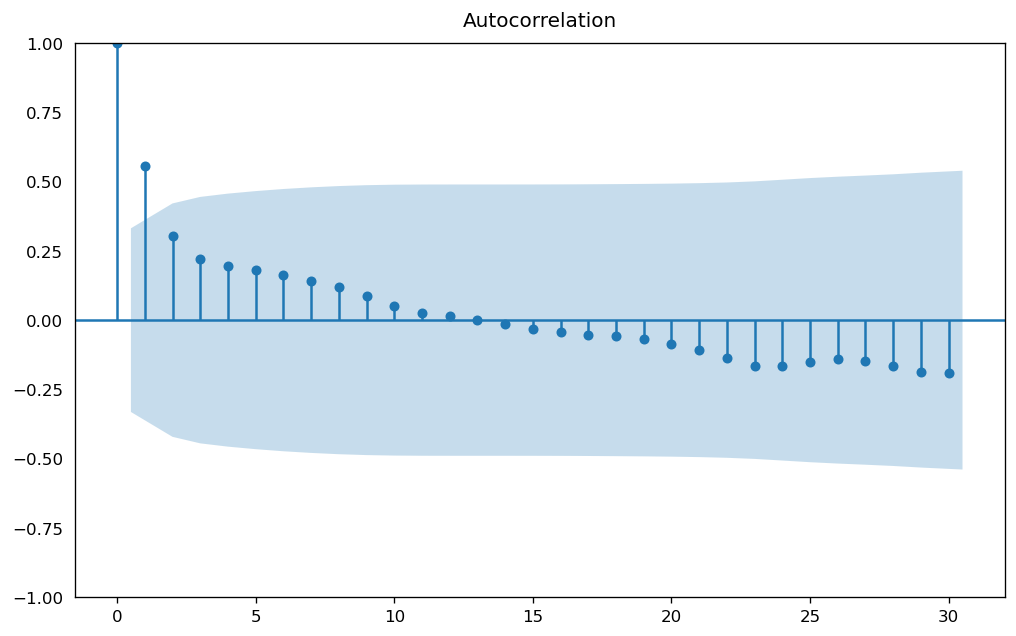

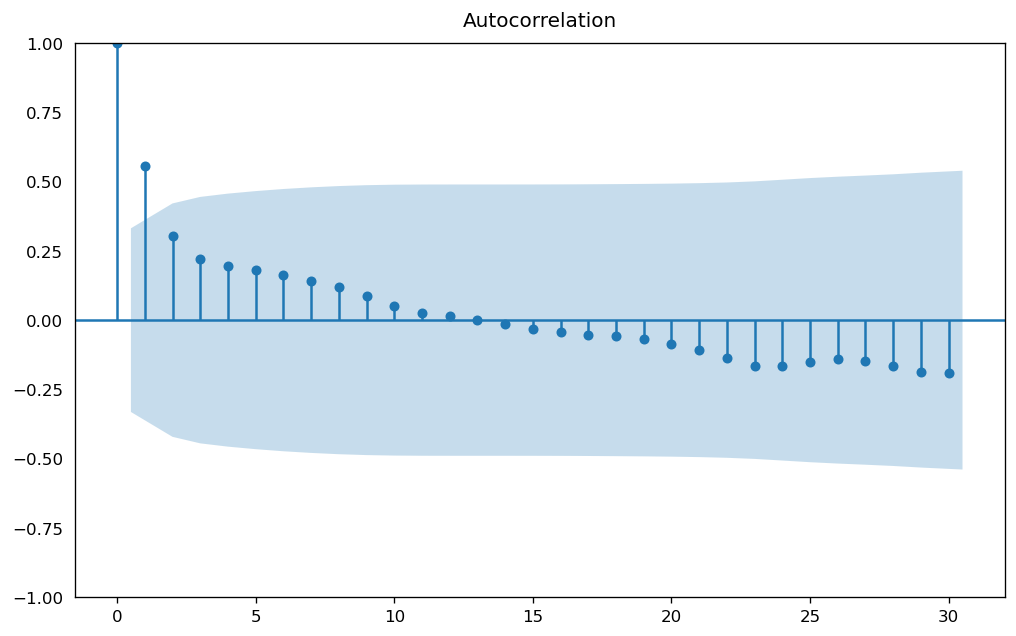

In [179]:
train_acf = acf(train, fft= True)
plot_acf(train_acf, lags = 30)

/Users/leostern/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


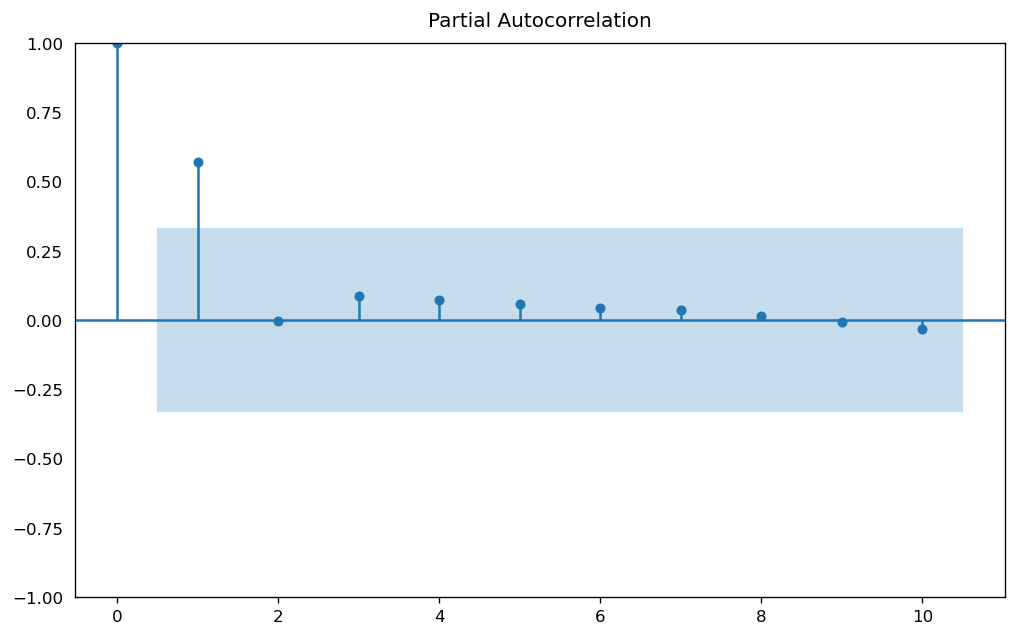

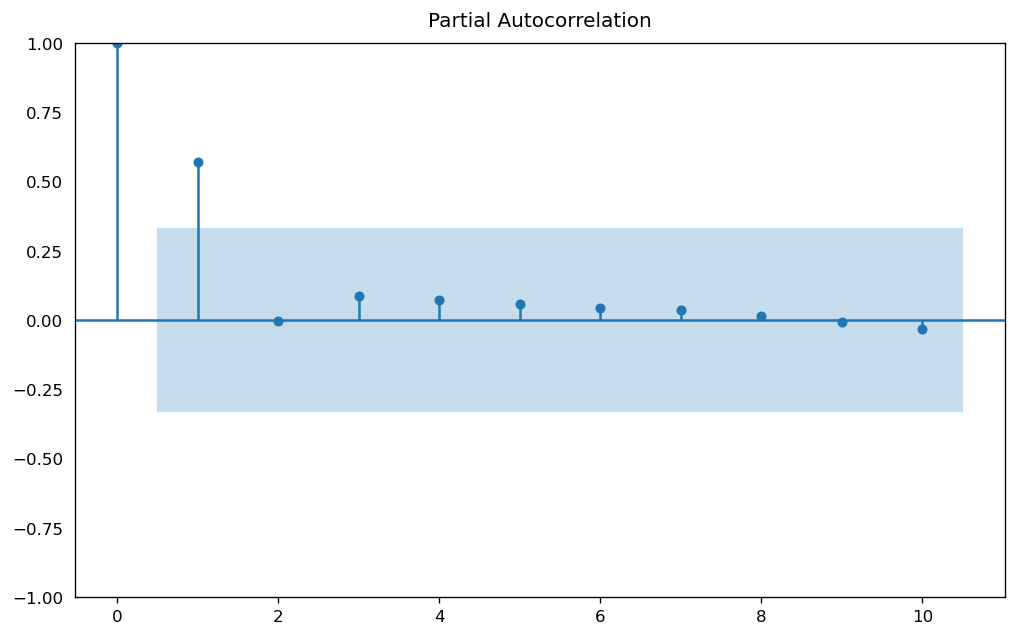

In [180]:
plot_pacf(train_acf, lags = 10)

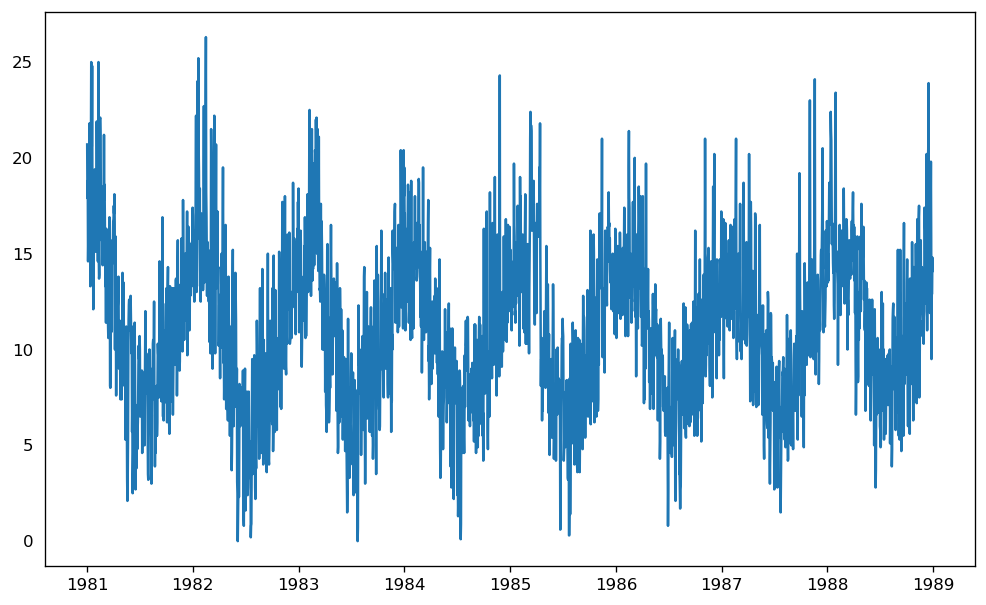

In [181]:
plt.plot(train)

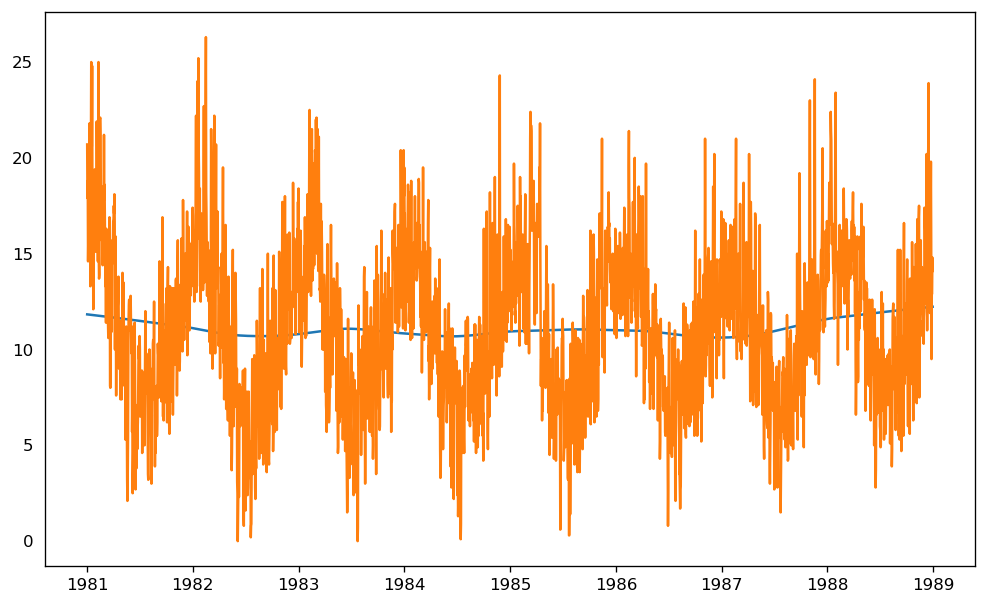

In [182]:
stl = STL(train, period = 365)
results = stl.fit()
plt.plot(results.trend)
plt.plot(train)

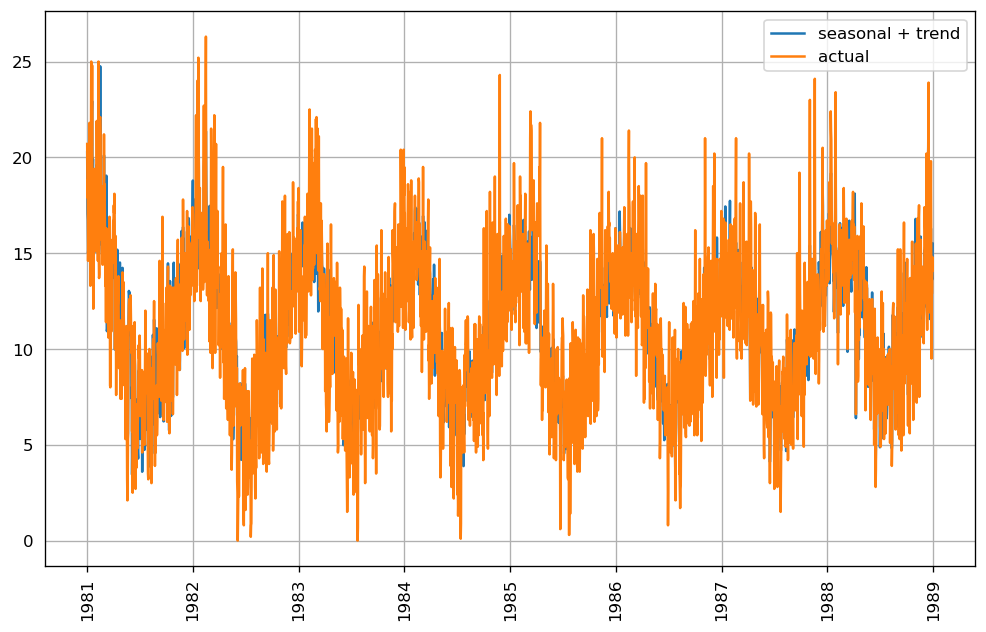

In [183]:
season_and_trend = results.seasonal + results.trend
plt.plot(season_and_trend['1981':], label = 'seasonal + trend')
plt.plot(train['1981':], label = 'actual')
plt.grid()
plt.legend()
plt.xticks(rotation = 90);

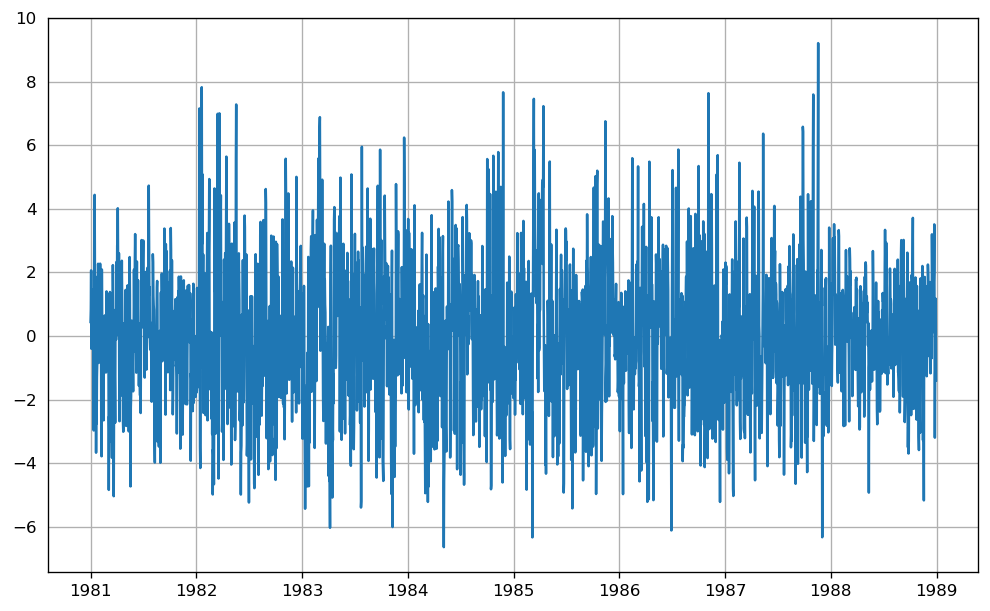

In [184]:
plt.plot(results.resid)
plt.grid()
# stationary

In [185]:
# Forecast Error
#instantiate
stlf = STLForecast(train, ARIMA, period = 365,  model_kwargs={'order':(1, 1, 0), 'trend':"t"})
#fit model using historical data
stlf_results = stlf.fit()
#produce forecast for future data
forecast = stlf_results.forecast(len(test))

/Users/leostern/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/leostern/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/leostern/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/leostern/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer ind

In [186]:
forecast

2920    13.372398
2921    13.676106
2922    13.526135
2923    15.388052
2924    14.810272
          ...    
3645    11.431468
3646    12.866760
3647    12.454294
3648    12.356723
3649    14.222133
Length: 730, dtype: float64

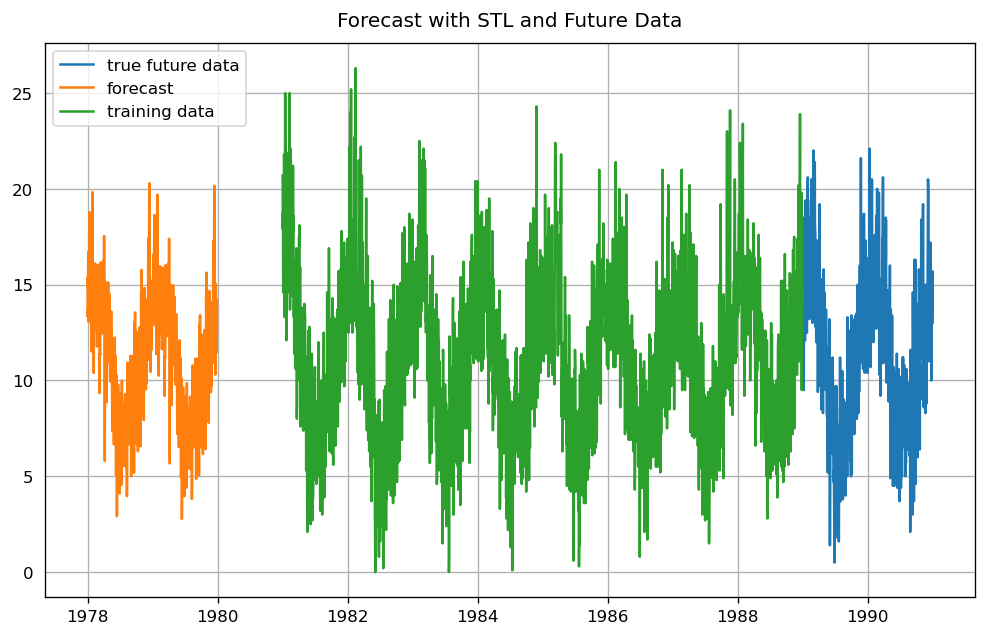

In [187]:
plt.plot(test, label = 'true future data')
plt.plot(forecast, label = 'forecast')
plt.plot(train, label = 'training data')
plt.legend()
plt.title('Forecast with STL and Future Data')
plt.grid();

In [189]:
# test = test.reset_index()
print(train.head())
print(test.head())
test.info()
train.info()

            Temp
Date            
1981-01-01  20.7
1981-01-02  17.9
1981-01-03  18.8
1981-01-04  14.6
1981-01-05  15.8
            Temp
Date            
1989-01-01  14.3
1989-01-02  17.4
1989-01-03  18.5
1989-01-04  16.8
1989-01-05  11.5
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 730 entries, 1989-01-01 to 1990-12-31
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Temp    730 non-null    float64
dtypes: float64(1)
memory usage: 11.4 KB
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2920 entries, 1981-01-01 to 1988-12-30
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Temp    2920 non-null   float64
dtypes: float64(1)
memory usage: 110.2 KB


In [176]:
stlf = STLForecast(train, ARIMA, period = 365,  model_kwargs={'order':(1, 1, 0), 'trend':"t"})
stlf_results = stlf.fit()
forecast = stlf_results.forecast(len(test))
forecast.head()

/Users/leostern/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/leostern/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/leostern/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/leostern/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer ind

2920    13.372398
2921    13.676106
2922    13.526135
2923    15.388052
2924    14.810272
dtype: float64

In [202]:
temps.head()

,Date,Temp,time
0,1981-01-01,20.7,1981-01-01
1,1981-01-02,17.9,1981-01-02
2,1981-01-03,18.8,1981-01-03
3,1981-01-04,14.6,1981-01-04
4,1981-01-05,15.8,1981-01-05


In [201]:
temps2['time'] = pd.to_datetime(temps2['Date'])
temp2 = temps.resample('M').ffill()
#temps2.set_index(pd.date_range(start= '01-01-1981',end = '12-30-1990', periods = 120 , )).drop('Date', axis = 1)

TypeError: Only valid with DatetimeIndex, TimedeltaIndex or PeriodIndex, but got an instance of 'RangeIndex'

In [ ]:
temp3 